In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

# Generate simulated data for RIS elements' characteristics (channel conditions, energy levels, signal reception)
num_elements = 300
elements = np.random.normal(0.5, 0.1, (num_elements, 4))  

Optimal Energy Group Indices: [145, 154, 97, 78, 266, 156, 237, 1, 210, 249, 236, 183, 11, 264, 242, 44, 199, 178, 270, 94, 240, 65, 57, 76, 73, 295, 63, 127, 273, 250, 100, 84, 50, 123, 150, 91, 111, 134, 85, 88, 224, 59, 2, 35, 27, 244, 93, 220, 67, 264, 184, 103, 6, 144, 66, 215, 173, 157, 8, 205, 201, 42, 60, 171, 243, 172, 153, 255, 255, 233, 256, 254, 193, 200, 275, 291, 196, 108, 41, 2, 139, 37, 46, 47, 258, 235, 18, 296, 290, 136, 107, 102, 160, 68, 177, 47, 285, 38, 34, 204, 21, 179, 294, 215, 30, 199, 140, 202, 25, 247, 175, 221, 269, 20, 78, 45, 107, 105, 202, 211, 81, 54, 203, 126, 115, 257, 147, 288, 118, 58, 56, 168, 131, 194, 281, 277, 117, 207, 40, 245, 271, 15, 160, 279, 72, 254, 165, 80, 96, 231]
Optimal Signal Group Indices: [0, 3, 4, 5, 7, 9, 10, 12, 13, 14, 16, 17, 19, 22, 23, 24, 26, 28, 29, 31, 32, 33, 36, 39, 43, 48, 49, 51, 52, 53, 55, 61, 62, 64, 69, 70, 71, 74, 75, 77, 79, 82, 83, 86, 87, 89, 90, 92, 95, 98, 99, 101, 104, 106, 109, 110, 113, 114, 116, 119, 12

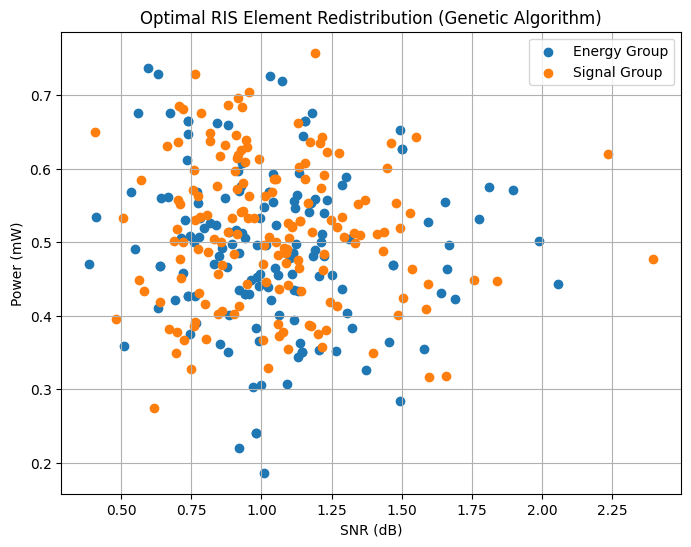

In [2]:
# Define channel gain and Rayleigh fading parameters
noise_power = np.random.rand() # The noise power is a random value between 0 and 1

# Genetic Algorithm parameters
population_size = 100
num_generations = 100
crossover_rate = 0.8
mutation_rate = 0.1


def calculate_snr_power(energy_indices, signal_indices):
    # Define the fading channel gain
    h = 0.5 # You can update this value based on your specific requirements
    # Define the power of the base station
    P_bs = 1 # The power of the base station is 1 W
    # Calculate the energy and signal power
    energy_power = np.sum(elements[energy_indices, 1])
    signal_power = np.sum(elements[signal_indices, 1])
    # This formula calculates the SNR by dividing the signal power by the sum of the energy power and noise power.
    snr = (P_bs * h * signal_power) / (P_bs * h * energy_power + noise_power)
    # Calculate the total power
    power = energy_power + signal_power
    return snr, power

def generate_initial_indices(channel_condition, fading):
    # Calculate the initial values for the energy_indices and signal_indices based on the channel condition and fading
    # For example, you could sort the elements based on their channel condition and fading, and select the top elements as the initial energy_indices
    sorted_indices = np.argsort(channel_condition * fading) 
    energy_indices = sorted_indices[:num_elements // 2]
    signal_indices = sorted_indices[num_elements // 2:]
    # Return the initial values for the energy_indices and signal_indices
    return energy_indices, signal_indices


def evaluate_fitness(energy_indices, signal_indices):
    snr, power = calculate_snr_power(energy_indices, signal_indices)
    return 1 / (snr * power)

def genetic_algorithm():
    # Define the channel condition and fading for each element as random values
    channel_condition = np.random.rand(num_elements)
    fading = np.random.rand(num_elements)

    # Generate the initial values for the energy_indices and signal_indices
    energy_indices, signal_indices = generate_initial_indices(channel_condition, fading)

    # Initialize the population of individuals in your genetic algorithm
    population = [energy_indices] * population_size

    for _ in range(num_generations):
        new_population = []
        for parent1, parent2 in zip(population[::2], population[1::2]):
            if np.random.rand() < crossover_rate:
                crossover_point = np.random.randint(1, num_elements // 2)
                child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
                child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            else:
                child1 = parent1
                child2 = parent2
            
            for child in [child1, child2]:
                if np.random.rand() < mutation_rate:
                    mutation_index = np.random.randint(num_elements // 2)
                    child[mutation_index] = np.random.randint(num_elements)
            new_population.extend([child1, child2])
        
        population = new_population
        
        best_individual = min(population, key=lambda ind: evaluate_fitness(ind, list(set(range(num_elements)) - set(ind))))
        
        best_energy_indices = best_individual
        best_signal_indices = list(set(range(num_elements)) - set(best_individual))
        best_snr, best_power = calculate_snr_power(best_energy_indices, best_signal_indices)
        
    return best_energy_indices, best_signal_indices, best_snr, best_power

def smarter_optimization(energy_indices, signal_indices):
    initial_snr, initial_power = calculate_snr_power(energy_indices, signal_indices)
    best_energy_indices = energy_indices.copy()
    best_signal_indices = signal_indices.copy()
    best_combined_improvement = 0
    
    for _ in range(100):  # Perform 10 iterations
        improved = False
        for energy_index in energy_indices:
            for signal_index in signal_indices:
                new_energy_indices = [idx for idx in energy_indices if idx != energy_index]
                new_signal_indices = [idx for idx in signal_indices if idx != signal_index]
                new_energy_indices.append(signal_index)
                new_signal_indices.append(energy_index)
                
                new_snr, new_power = calculate_snr_power(new_energy_indices, new_signal_indices)
                snr_improvement = new_snr - initial_snr
                power_reduction = initial_power - new_power
                combined_improvement_metric = snr_improvement - 0.5 * power_reduction
                
                if combined_improvement_metric > best_combined_improvement:
                    best_combined_improvement = combined_improvement_metric
                    best_energy_indices = new_energy_indices
                    best_signal_indices = new_signal_indices
                    improved = True
        
        if not improved:
            break
    
    return best_energy_indices, best_signal_indices, best_combined_improvement

# Define the distance between the end user and the access point
user_distance = 100  # Example distance in meters

# Calculate the initial SNR for the end user without RIS-UAV system
initial_snr_without_ris = 1 / (user_distance ** 2)

# Run the Genetic Algorithm
best_energy_indices, best_signal_indices, best_snr, best_power = genetic_algorithm()

# Apply the smarter optimization strategy
best_energy_indices, best_signal_indices, combined_improvement_metric = smarter_optimization(best_energy_indices, best_signal_indices)

# Calculate initial SNR and power
initial_snr, initial_power = calculate_snr_power(range(num_elements // 2), range(num_elements // 2, num_elements))

# Calculate the improved SNR with RIS-UAV system
improved_snr_with_ris = 1 / (2 * best_snr)

# Calculate initial SNR in dB and improved SNR in dB
initial_snr_dB = 10 * np.log10(initial_snr_without_ris)
improved_snr_dB = 10 * np.log10(improved_snr_with_ris)

# Calculate efficiency metrics
snr_improvement_percentage = (abs(improved_snr_dB - initial_snr_dB) / initial_snr_dB) * 100

# snr_improvement_percentage = (abs(best_snr - initial_snr) / initial_snr) * 100
power_reduction_percentage = (abs(initial_power - best_power) / initial_power) * 100
energy_efficiency = (best_snr * best_power) / num_elements

# Print optimal groupings and their characteristics
print("Optimal Energy Group Indices:", best_energy_indices)
print("Optimal Signal Group Indices:", best_signal_indices)
print("Initial SNR:", initial_snr, "dB")
print("Initial Power:", initial_power, "mW")
print("Optimal SNR:", best_snr, "dB")
print("Optimal Power:", best_power, "mW")
# print("SNR Improvement Percentage:", snr_improvement_percentage, "%")
# print("Power Reduction Percentage:", power_reduction_percentage, "%")
print("Energy Efficiency:", energy_efficiency, "(SNR * Power / Num Elements)")
print("Combined Improvement Metric:", combined_improvement_metric)

# Visualize the efficiency
plt.figure(figsize=(8, 6))
plt.scatter(elements[best_energy_indices, 0] / elements[best_energy_indices, 2], elements[best_energy_indices, 1], label='Energy Group')
plt.scatter(elements[best_signal_indices, 0] / elements[best_signal_indices, 2], elements[best_signal_indices, 1], label='Signal Group')
plt.xlabel('SNR (dB)')
plt.ylabel('Power (mW)')
plt.title('Optimal RIS Element Redistribution (Genetic Algorithm)')
plt.legend()
plt.grid(True)
plt.show()